In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from aves.features.utils import normalize_rows, tfidf
from aves.models.datafusion import DataFusionModel

from gensim.utils import deaccent
from sklearn.metrics.pairwise import cosine_similarity

sns.set(
    style="whitegrid", context="paper", font_scale=0.8, font="Fira Sans Extra Condensed"
)
mpl.rcParams["figure.dpi"] = 150


In [149]:
casen = pd.read_stata(
    "../data/external/casen_2017/Casen 2017.dta", convert_categoricals=False
)
casen.head()


,folio,o,id_vivienda,hogar,region,provincia,comuna,zona,expr,expc,...,hh_d_estado,hh_d_servbas,hh_d_entorno,hh_d_accesi,hh_d_medio,hh_d_appart,hh_d_tsocial,hh_d_seg,pobreza_multi_4d,pobreza_multi_5d
0,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN
1,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN
3,1.101100e+11,2.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN
4,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,1.0,1.0,1.0,0.0,1.0,NaN,1.0,0.0,0.0,NaN


In [150]:
comunas = casen["comuna"].unique().astype(int)
comunas


array([ 1101,  1107,  1401,  1402,  1404,  1405,  2101,  2102,  2103,
        2104,  2201,  2203,  2301,  2302,  3101,  3102,  3103,  3201,
        3202,  3301,  3302,  3303,  3304,  4101,  4102,  4103,  4104,
        4105,  4106,  4201,  4202,  4203,  4204,  4301,  4302,  4303,
        4304,  4305,  5101,  5102,  5103,  5105,  5107,  5109,  5301,
        5302,  5303,  5304,  5401,  5402,  5403,  5404,  5405,  5501,
        5502,  5503,  5504,  5506,  5601,  5602,  5603,  5604,  5605,
        5606,  5701,  5702,  5703,  5704,  5705,  5706,  5801,  5802,
        5803,  5804,  6101,  6102,  6103,  6104,  6105,  6106,  6107,
        6108,  6109,  6110,  6111,  6112,  6113,  6114,  6115,  6116,
        6117,  6201,  6202,  6203,  6204,  6205,  6206,  6301,  6302,
        6303,  6304,  6305,  6306,  6307,  6308,  6309,  6310,  7101,
        7102,  7103,  7104,  7105,  7106,  7107,  7108,  7109,  7110,
        7201,  7202,  7203,  7301,  7302,  7303,  7304,  7305,  7306,
        7307,  7308,

In [151]:
len(comunas)


324

In [152]:
casen_2020 = pd.read_stata(
    "../data/external/casen_2020/Casen en Pandemia 2020 STATA.dta"
)
casen_2020.head()


/home/egraells/miniconda3/envs/chilean_voter_profiling/lib/python3.7/site-packages/pandas/io/stata.py:1457: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


,folio,o,id_persona,id_vivienda,region,provincia,comuna,zona,area,segmento,...,v27,v28,v29,hacinamiento,nhog_viv,indsan,ten_viv,ten_viv_f,iae,iai
0,1.101100e+11,1,5,1.101100e+09,Región de Tarapacá,Iquique,Iquique,Urbano,Urbano,11011001,...,1,NaN,NaN,"Sin hacinamiento (menos de 2,5 personas por do...",1,Deficitario,Arrendada,Tenencia informal,Sin allegamiento externo,sin allegamiento interno
1,1.101100e+11,2,6,1.101100e+09,Región de Tarapacá,Iquique,Iquique,Urbano,Urbano,11011001,...,1,NaN,NaN,"Sin hacinamiento (menos de 2,5 personas por do...",1,Deficitario,Arrendada,Tenencia informal,Sin allegamiento externo,sin allegamiento interno
2,1.101100e+11,2,31,1.101100e+09,Región de Tarapacá,Iquique,Iquique,Urbano,Urbano,11011001,...,1,NaN,NaN,"Hacinamiento medio (entre 2,5 y 3,49 personas ...",1,Aceptable,Arrendada,Tenencia formal,Sin allegamiento externo,sin allegamiento interno
3,1.101100e+11,1,32,1.101100e+09,Región de Tarapacá,Iquique,Iquique,Urbano,Urbano,11011001,...,1,NaN,NaN,"Hacinamiento medio (entre 2,5 y 3,49 personas ...",1,Aceptable,Arrendada,Tenencia formal,Sin allegamiento externo,sin allegamiento interno
4,1.101100e+11,3,30,1.101100e+09,Región de Tarapacá,Iquique,Iquique,Urbano,Urbano,11011001,...,1,NaN,NaN,"Hacinamiento medio (entre 2,5 y 3,49 personas ...",1,Aceptable,Arrendada,Tenencia formal,Sin allegamiento externo,sin allegamiento interno


In [3]:
elecciones = pd.read_csv(
    "../data/external/presidenciales_2021/Servel_20211121_PRESIDENCIALES_CHILE.csv",
    sep=";",
)
elecciones.head()


,eleccion_id,eleccion_nombre,region_id,region_nombre,provincia_id,provincia_nombre,comuna_id,comuna_nombre,circele_id,circele_nombre,...,codigo_colegio,nombre_colegio,sede_colegio,cs_id,cs,distrito_id,distrito,lista,pacto,partido_politico
0,4,Elección de Presidente 2021 ...,3001,DE TARAPACA ...,4011,IQUIQUE ...,2501,IQUIQUE ...,7007,IQUIQUE ...,...,101,LICEO DEPORTIVO ELENA DUVAUCHELLE CABEZON ...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,CONVERGENCIA SOCIAL ...
1,4,Elección de Presidente 2021 ...,3001,DE TARAPACA ...,4011,IQUIQUE ...,2501,IQUIQUE ...,7007,IQUIQUE ...,...,101,LICEO DEPORTIVO ELENA DUVAUCHELLE CABEZON ...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,PARTIDO REPUBLICANO DE CHILE ...
2,4,Elección de Presidente 2021 ...,3001,DE TARAPACA ...,4011,IQUIQUE ...,2501,IQUIQUE ...,7007,IQUIQUE ...,...,101,LICEO DEPORTIVO ELENA DUVAUCHELLE CABEZON ...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,PARTIDO DEMOCRATA CRISTIANO ...
3,4,Elección de Presidente 2021 ...,3001,DE TARAPACA ...,4011,IQUIQUE ...,2501,IQUIQUE ...,7007,IQUIQUE ...,...,101,LICEO DEPORTIVO ELENA DUVAUCHELLE CABEZON ...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,EVOLUCION POLITICA ...
4,4,Elección de Presidente 2021 ...,3001,DE TARAPACA ...,4011,IQUIQUE ...,2501,IQUIQUE ...,7007,IQUIQUE ...,...,101,LICEO DEPORTIVO ELENA DUVAUCHELLE CABEZON ...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,UNION PATRIOTICA ...


In [4]:
elecciones.columns

Index(['eleccion_id', 'eleccion_nombre', 'region_id', 'region_nombre',
       'provincia_id', 'provincia_nombre', 'comuna_id', 'comuna_nombre',
       'circele_id', 'circele_nombre', 'local_id', 'local_nombre', 'mesa_id',
       'mesas_fusionadas', 'mesa_electores', 'mesa_numero', 'tipomesa',
       'mesa_descuadrada_preliminar', 'mesa_descuadrada_provisorio',
       'candidato', 'votos_preliminar_string', 'votos_provisorio_string',
       'nvoto', 'electo', 'codigo_colegio', 'nombre_colegio', 'sede_colegio',
       'cs_id', 'cs', 'distrito_id', 'distrito', 'lista', 'pacto',
       'partido_politico'],
      dtype='object')

In [122]:
elecciones['location_name'] = elecciones['local_nombre'].str.replace(r'LOCAL: \d+', '').str.strip()
elecciones['location_name']

/home/egraells/miniconda3/envs/chilean_voter_profiling/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


0           LICEO LUIS CRUZ MARTINEZ
1           LICEO LUIS CRUZ MARTINEZ
2           LICEO LUIS CRUZ MARTINEZ
3           LICEO LUIS CRUZ MARTINEZ
4           LICEO LUIS CRUZ MARTINEZ
                     ...            
513024    LICEO TECNICO PUENTE ÑUBLE
513025    LICEO TECNICO PUENTE ÑUBLE
513026    LICEO TECNICO PUENTE ÑUBLE
513027    LICEO TECNICO PUENTE ÑUBLE
513028    LICEO TECNICO PUENTE ÑUBLE
Name: location_name, Length: 513029, dtype: object

In [123]:
elecciones['region_nombre'] = elecciones['region_nombre'].str.strip()

In [139]:
codes = pd.read_excel("../data/external/CUT_2018_v04.xls")
codes


,Código Región,Nombre Región,Abreviatura Región,Código Provincia,Nombre Provincia,Código Comuna 2018,Nombre Comuna
0,1,Tarapacá,TPCA,11,Iquique,1101,Iquique
1,1,Tarapacá,TPCA,11,Iquique,1107,Alto Hospicio
2,1,Tarapacá,TPCA,14,Tamarugal,1401,Pozo Almonte
3,1,Tarapacá,TPCA,14,Tamarugal,1402,Camiña
4,1,Tarapacá,TPCA,14,Tamarugal,1403,Colchane
...,...,...,...,...,...,...,...
341,16,Ñuble,NUBLE,163,Punilla,16301,San Carlos
342,16,Ñuble,NUBLE,163,Punilla,16302,Coihueco
343,16,Ñuble,NUBLE,163,Punilla,16303,Ñiquén
344,16,Ñuble,NUBLE,163,Punilla,16304,San Fabián


In [140]:
codes["comuna_nombre"] = codes["Nombre Comuna"].str.upper().map(deaccent)
codes["comuna_nombre"]


0            IQUIQUE
1      ALTO HOSPICIO
2       POZO ALMONTE
3             CAMINA
4           COLCHANE
           ...      
341       SAN CARLOS
342         COIHUECO
343           NIQUEN
344       SAN FABIAN
345      SAN NICOLAS
Name: comuna_nombre, Length: 346, dtype: object

In [141]:
codes["Código Región"].unique()


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [142]:
comunas_x_region = pd.get_dummies(codes.set_index("comuna_nombre")["Código Región"])
comunas_x_region


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
comuna_nombre,,,,,,,,,,,,,,,,
IQUIQUE,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ALTO HOSPICIO,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
POZO ALMONTE,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CAMINA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
COLCHANE,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAN CARLOS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
COIHUECO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
NIQUEN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [143]:
elecciones["votos_preliminar_string_strip"] = (
    elecciones["votos_preliminar_string"]
    .str.strip()
    .str.replace(r"^$", "0")
    .astype(int)
)


/home/egraells/miniconda3/envs/chilean_voter_profiling/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [144]:
elecciones.groupby("candidato")["votos_preliminar_string_strip"].sum()


candidato
EDUARDO ARTES BRICHETTI                                                                                  102493
FRANCO PARISI FERNANDEZ                                                                                  898407
GABRIEL BORIC FONT                                                                                      1796664
JOSE ANTONIO KAST RIST                                                                                  1954053
MARCO ENRIQUEZ-OMINAMI GUMUCIO                                                                           533657
SEBASTIAN SICHEL RAMIREZ                                                                                 894800
Total Sufragios Emitidos                                                                                7036860
Total Suma Calculada                                                                                    7036860
Votos Blancos                                                                                 

In [145]:
elecciones["comuna_nombre"] = elecciones["comuna_nombre"].str.strip()
elecciones["comuna_nombre"]


0             IQUIQUE
1             IQUIQUE
2             IQUIQUE
3             IQUIQUE
4             IQUIQUE
             ...     
513024    SAN NICOLAS
513025    SAN NICOLAS
513026    SAN NICOLAS
513027    SAN NICOLAS
513028    SAN NICOLAS
Name: comuna_nombre, Length: 513029, dtype: object

In [146]:
turnout = (
    elecciones.groupby(["comuna_nombre", "candidato"])["votos_preliminar_string_strip"]
    .sum()
    .unstack()
)
turnout.head()


candidato,EDUARDO ARTES BRICHETTI,FRANCO PARISI FERNANDEZ,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,MARCO ENRIQUEZ-OMINAMI GUMUCIO,SEBASTIAN SICHEL RAMIREZ,Total Sufragios Emitidos,Total Suma Calculada,Votos Blancos,Votos Nulos,YASNA PROVOSTE CAMPILLAY
comuna_nombre,,,,,,,,,,,
ALGARROBO,90,568,1978,2877,472,1352,8217,8217,20,43,817
ALHUE,31,357,636,467,151,320,2517,2517,16,19,520
ALTO BIOBIO,40,255,377,502,119,155,1997,1997,80,81,399
ALTO DEL CARMEN,11,365,260,265,56,87,1966,1966,14,15,891
ALTO HOSPICIO,263,9884,3183,5860,1712,1212,24579,24579,70,173,2212


In [147]:
turnout.columns = list(map(lambda x: x.strip(), turnout.columns))
turnout.columns


Index(['EDUARDO ARTES BRICHETTI', 'FRANCO PARISI FERNANDEZ',
       'GABRIEL BORIC FONT', 'JOSE ANTONIO KAST RIST',
       'MARCO ENRIQUEZ-OMINAMI GUMUCIO', 'SEBASTIAN SICHEL RAMIREZ',
       'Total Sufragios Emitidos', 'Total Suma Calculada', 'Votos Blancos',
       'Votos Nulos', 'YASNA PROVOSTE CAMPILLAY'],
      dtype='object')

In [153]:
casen_comunas = casen.join(
    codes.set_index("Código Comuna 2018")["comuna_nombre"], on="comuna"
)
casen_comunas


,folio,o,id_vivienda,hogar,region,provincia,comuna,zona,expr,expc,...,hh_d_servbas,hh_d_entorno,hh_d_accesi,hh_d_medio,hh_d_appart,hh_d_tsocial,hh_d_seg,pobreza_multi_4d,pobreza_multi_5d,comuna_nombre
0,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,IQUIQUE
1,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,IQUIQUE
2,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,IQUIQUE
3,1.101100e+11,2.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,IQUIQUE
4,1.101100e+11,1.0,1.101100e+09,1.0,1.0,11.0,1101.0,1.0,39.0,33.0,...,1.0,1.0,0.0,1.0,NaN,1.0,0.0,0.0,NaN,IQUIQUE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216434,1.520130e+12,1.0,1.520130e+10,1.0,15.0,152.0,15201.0,2.0,7.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,PUTRE
216435,1.520130e+12,2.0,1.520130e+10,1.0,15.0,152.0,15201.0,2.0,7.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,PUTRE
216436,1.520130e+12,1.0,1.520130e+10,1.0,15.0,152.0,15201.0,2.0,7.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,PUTRE
216437,1.520130e+12,2.0,1.520130e+10,1.0,15.0,152.0,15201.0,2.0,7.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,PUTRE


In [154]:
casen_2020["comuna_nombre"] = casen_2020["comuna"].str.upper().map(deaccent)


/home/egraells/miniconda3/envs/chilean_voter_profiling/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.


In [155]:
poblacion_comunas = (
    casen_2020[casen_2020["edad"] >= 17].groupby("comuna_nombre")["expr"].sum()
)
poblacion_comunas


comuna_nombre
ALGARROBO          12470.0
ALHUE               5344.0
ALTO BIOBIO         3777.0
ALTO DEL CARMEN     5308.0
ALTO HOSPICIO      95878.0
                    ...   
VITACURA           54274.0
YERBAS BUENAS      12665.0
YUMBEL             15425.0
YUNGAY             17247.0
ZAPALLAR            6768.0
Name: expr, Length: 324, dtype: float64

In [156]:
poblacion_comunas.sum()


15337420.0

In [157]:
candidatos = [
    "EDUARDO ARTES BRICHETTI",
    "GABRIEL BORIC FONT",
    "JOSE ANTONIO KAST RIST",
    "MARCO ENRIQUEZ-OMINAMI GUMUCIO",
    "FRANCO PARISI FERNANDEZ",
    "YASNA PROVOSTE CAMPILLAY",
    "SEBASTIAN SICHEL RAMIREZ",
]
columnas_votos = candidatos + ["Votos Blancos", "Votos Nulos"]
columnas_votos


['EDUARDO ARTES BRICHETTI',
 'GABRIEL BORIC FONT',
 'JOSE ANTONIO KAST RIST',
 'MARCO ENRIQUEZ-OMINAMI GUMUCIO',
 'FRANCO PARISI FERNANDEZ',
 'YASNA PROVOSTE CAMPILLAY',
 'SEBASTIAN SICHEL RAMIREZ',
 'Votos Blancos',
 'Votos Nulos']

In [158]:
turnout = (
    turnout.reset_index()
    .assign(comuna_nombre=lambda x: x["comuna_nombre"].map(deaccent))
    .set_index("comuna_nombre")[columnas_votos]
)


In [159]:
total_votos = turnout[columnas_votos].sum(axis=1)
total_votos


comuna_nombre
ALGARROBO            8217
ALHUE                2517
ALTO BIOBIO          2008
ALTO DEL CARMEN      1964
ALTO HOSPICIO       24569
                    ...  
YUMBEL               8771
YUNGAY               6863
ZAPALLAR             5461
NIQUEN               4731
NUNOA              123001
Length: 346, dtype: int64

In [160]:
abstencion = (poblacion_comunas - total_votos).rename("Abstención")
abstencion


comuna_nombre
ALGARROBO           4253.0
ALHUE               2827.0
ALTO BIOBIO         1769.0
ALTO DEL CARMEN     3344.0
ALTO HOSPICIO      71309.0
                    ...   
VITACURA           -7472.0
YERBAS BUENAS       6224.0
YUMBEL              6654.0
YUNGAY             10384.0
ZAPALLAR            1307.0
Name: Abstención, Length: 349, dtype: float64

In [161]:
abstencion[abstencion < 0]


comuna_nombre
CAMARONES       -251.0
EL TABO        -2182.0
PUTRE           -752.0
RANQUIL         -967.0
SIERRA GORDA     -16.0
VITACURA       -7472.0
Name: Abstención, dtype: float64

In [162]:
turnout = turnout.join(abstencion, how="left")[columnas_votos + ["Abstención"]]


In [163]:
turnout.sum()


EDUARDO ARTES BRICHETTI            102493.0
GABRIEL BORIC FONT                1796664.0
JOSE ANTONIO KAST RIST            1954053.0
MARCO ENRIQUEZ-OMINAMI GUMUCIO     533657.0
FRANCO PARISI FERNANDEZ            898407.0
YASNA PROVOSTE CAMPILLAY           813418.0
SEBASTIAN SICHEL RAMIREZ           894800.0
Votos Blancos                       31256.0
Votos Nulos                         57266.0
Abstención                        8267842.0
dtype: float64

## Matrices por comunas

In [166]:
comunas_x_ingreso = (
    casen_comunas.groupby(["comuna_nombre", "dautr"])["expr"]
    .sum()
    .unstack(fill_value=0)
)
comunas_x_ingreso


dautr,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
comuna_nombre,,,,,,,,,,
AISEN,2998.0,3022.0,3181.0,2176.0,2389.0,1932.0,2858.0,2016.0,1242.0,1044.0
ALGARROBO,570.0,1520.0,300.0,1005.0,492.0,746.0,1085.0,1424.0,1242.0,1533.0
ALHUE,682.0,1324.0,1210.0,461.0,986.0,1580.0,612.0,307.0,352.0,66.0
ALTO BIOBIO,2786.0,1331.0,806.0,254.0,847.0,284.0,501.0,245.0,82.0,79.0
ALTO DEL CARMEN,320.0,648.0,164.0,598.0,168.0,546.0,278.0,20.0,76.0,96.0
...,...,...,...,...,...,...,...,...,...,...
VITACURA,237.0,0.0,102.0,0.0,1252.0,1278.0,2482.0,5345.0,12378.0,26603.0
YERBAS BUENAS,1117.0,2824.0,1168.0,670.0,2183.0,1659.0,530.0,1280.0,1187.0,654.0
YUMBEL,4438.0,2153.0,1390.0,2755.0,2320.0,3180.0,224.0,1257.0,292.0,320.0


In [167]:
comunas_index = turnout.join(comunas_x_ingreso, how="inner").index
comunas_index


Index(['ALGARROBO', 'ALHUE', 'ALTO BIOBIO', 'ALTO DEL CARMEN', 'ALTO HOSPICIO',
       'ANCUD', 'ANDACOLLO', 'ANGOL', 'ANTOFAGASTA', 'ANTUCO',
       ...
       'VILLA ALEMANA', 'VILLARRICA', 'VITACURA', 'VINA DEL MAR',
       'YERBAS BUENAS', 'YUMBEL', 'YUNGAY', 'ZAPALLAR', 'NIQUEN', 'NUNOA'],
      dtype='object', name='comuna_nombre', length=319)

In [168]:
comunas_x_ingreso = comunas_x_ingreso.loc[comunas_index]
comunas_x_ingreso


dautr,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
comuna_nombre,,,,,,,,,,
ALGARROBO,570.0,1520.0,300.0,1005.0,492.0,746.0,1085.0,1424.0,1242.0,1533.0
ALHUE,682.0,1324.0,1210.0,461.0,986.0,1580.0,612.0,307.0,352.0,66.0
ALTO BIOBIO,2786.0,1331.0,806.0,254.0,847.0,284.0,501.0,245.0,82.0,79.0
ALTO DEL CARMEN,320.0,648.0,164.0,598.0,168.0,546.0,278.0,20.0,76.0,96.0
ALTO HOSPICIO,17502.0,18871.0,14433.0,12312.0,10314.0,11591.0,8153.0,5716.0,4149.0,1991.0
...,...,...,...,...,...,...,...,...,...,...
YUMBEL,4438.0,2153.0,1390.0,2755.0,2320.0,3180.0,224.0,1257.0,292.0,320.0
YUNGAY,2410.0,6342.0,2457.0,1866.0,3184.0,3149.0,1528.0,1595.0,2831.0,1606.0
ZAPALLAR,179.0,733.0,1363.0,330.0,394.0,745.0,243.0,171.0,496.0,230.0


In [169]:
comunas_x_drogas = (
    casen_comunas.groupby(["comuna_nombre", "v38b"])["expr"]
    .sum()
    .unstack(fill_value=0)
    .loc[comunas_index]
)
comunas_x_drogas.columns = ["Nunca", "Pocas veces", "Muchas veces", "Siempre", "N/A"]
comunas_x_drogas


,Nunca,Pocas veces,Muchas veces,Siempre,N/A
comuna_nombre,,,,,
ALGARROBO,8050.0,1285.0,164.0,469.0,0.0
ALHUE,5264.0,948.0,760.0,608.0,0.0
ALTO BIOBIO,5714.0,1072.0,299.0,130.0,0.0
ALTO DEL CARMEN,2622.0,272.0,20.0,0.0,0.0
ALTO HOSPICIO,35030.0,35499.0,19233.0,15270.0,0.0
...,...,...,...,...,...
YUMBEL,14563.0,2356.0,1125.0,285.0,0.0
YUNGAY,21385.0,2285.0,1372.0,2001.0,0.0
ZAPALLAR,3878.0,629.0,176.0,201.0,0.0


In [170]:
column_map = {1: "prepaid", 2: "contract", 3: "prepaid_and_contract", 4: "no", 9: "n/a"}

comunas_x_moviles = (
    casen_comunas.pivot_table(
        index="comuna_nombre", columns="r22", values="expr", aggfunc="sum"
    )
    .fillna(0)
    .loc[comunas_index]
)
comunas_x_moviles.columns = comunas_x_moviles.columns.map(lambda x: column_map[int(x)])
comunas_x_moviles


r22,prepaid,contract,prepaid_and_contract,no,n/a
comuna_nombre,,,,,
ALGARROBO,4038.0,4232.0,87.0,813.0,115.0
ALHUE,4303.0,2205.0,0.0,586.0,129.0
ALTO BIOBIO,4710.0,205.0,46.0,1803.0,67.0
ALTO DEL CARMEN,1678.0,424.0,0.0,602.0,20.0
ALTO HOSPICIO,52923.0,22103.0,1184.0,15965.0,2223.0
...,...,...,...,...,...
YUMBEL,11728.0,1871.0,0.0,3067.0,521.0
YUNGAY,14449.0,7364.0,667.0,2750.0,0.0
ZAPALLAR,2277.0,1962.0,0.0,420.0,53.0


In [171]:
comunas_x_trabajo = (
    casen_2020.groupby(["comuna_nombre", "o15"])["expr"]
    .sum()
    .unstack(fill_value=0)
    .loc[comunas_index]
)
comunas_x_trabajo


o15,Patrón o empleador,Trabajador por cuenta propia,Empleado u obrero del sector público (Gobierno Central o Municipal),Empleado u obrero de empresas públicas,Empleado u obrero del sector privado,Servicio doméstico puertas adentro,Servicio doméstico puertas afuera,FF.AA. y del Orden,Familiar no remunerado
comuna_nombre,,,,,,,,,
ALGARROBO,216.0,1948.0,472.0,555.0,2850.0,74.0,118.0,0.0,17.0
ALHUE,79.0,401.0,187.0,110.0,1736.0,0.0,29.0,0.0,104.0
ALTO BIOBIO,0.0,601.0,500.0,504.0,351.0,0.0,59.0,0.0,43.0
ALTO DEL CARMEN,34.0,814.0,234.0,34.0,1314.0,0.0,34.0,0.0,0.0
ALTO HOSPICIO,1713.0,15363.0,4150.0,2960.0,26358.0,35.0,593.0,192.0,667.0
...,...,...,...,...,...,...,...,...,...
YUMBEL,206.0,1241.0,264.0,288.0,2210.0,0.0,206.0,467.0,86.0
YUNGAY,237.0,1311.0,294.0,325.0,4263.0,0.0,76.0,0.0,0.0
ZAPALLAR,112.0,1014.0,421.0,306.0,875.0,170.0,569.0,0.0,0.0


In [172]:
comunas_x_oficio = (
    casen_2020.groupby(["comuna_nombre", "oficio1_88"])["expr"]
    .sum()
    .unstack(fill_value=0)
    .loc[comunas_index]
)
comunas_x_oficio


oficio1_88,Fuerzas armadas,Miembros del poder ejecutivo y de los cuerpos legislativos y personal directivo de la administración pública y de empresas,"Profesionales, científicos e intelectuales",Técnicos y profesionales de nivel medio,Empleados de oficina,Trabajadores de los servicios y vendedores de comercios y mercados,Agricultores y trabajadores calificados agropecuarios y pesqueros,"Oficiales, operarios y artesanos de artes mecánicas y de otros oficios",Operadores de instalaciones y máquinas y montadores,Trabajadores no calificados,No bien especificado,No responde
comuna_nombre,,,,,,,,,,,,
ALGARROBO,0.0,324.0,501.0,417.0,386.0,1196.0,29.0,934.0,266.0,2140.0,57.0,0.0
ALHUE,0.0,58.0,146.0,209.0,217.0,356.0,0.0,358.0,295.0,948.0,59.0,0.0
ALTO BIOBIO,0.0,30.0,201.0,262.0,72.0,506.0,88.0,291.0,8.0,212.0,388.0,0.0
ALTO DEL CARMEN,0.0,0.0,96.0,154.0,148.0,130.0,130.0,390.0,352.0,1064.0,0.0,0.0
ALTO HOSPICIO,277.0,2074.0,4770.0,3027.0,4915.0,9000.0,377.0,9803.0,6063.0,10786.0,862.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...
YUMBEL,0.0,467.0,500.0,143.0,307.0,715.0,233.0,554.0,285.0,1506.0,258.0,0.0
YUNGAY,0.0,61.0,843.0,147.0,527.0,930.0,104.0,921.0,968.0,1963.0,42.0,0.0
ZAPALLAR,0.0,164.0,220.0,256.0,158.0,383.0,150.0,465.0,127.0,1544.0,0.0,0.0


In [173]:
comunas_x_origen = (
    casen_2020.groupby(["comuna_nombre", "r1b"])["expr"]
    .sum()
    .unstack(fill_value=0)
    .loc[comunas_index]
)
comunas_x_origen


r1b,En [comuna de ubicación la vivienda],En otra comuna de Chile. Especifique ¿cuál comuna?,En otro país. Especifique ¿cuál país?,No sabe
comuna_nombre,,,,
ALGARROBO,5704.0,9058.0,533.0,291.0
ALHUE,4153.0,2334.0,579.0,42.0
ALTO BIOBIO,3318.0,1619.0,16.0,460.0
ALTO DEL CARMEN,4840.0,2374.0,0.0,34.0
ALTO HOSPICIO,42352.0,76074.0,15607.0,2322.0
...,...,...,...,...
YUMBEL,12158.0,6549.0,104.0,97.0
YUNGAY,16783.0,6513.0,0.0,395.0
ZAPALLAR,3870.0,4118.0,134.0,113.0


In [174]:
comunas_x_migrantes = (
    casen_2020.groupby(["comuna_nombre", "r1b_p_cod"])["expr"]
    .sum()
    .unstack(fill_value=0)
    .loc[comunas_index]
)
comunas_x_migrantes


r1b_p_cod,Alemania,Austria,Bélgica,Bielorrusia,Croacia,Dinamarca,España,Finlandia,Francia,Holanda,...,Guyana,Paraguay,Perú,Uruguay,Venezuela,Australia,Nueva Zelanda,Palestina,No bien especificado,No responde
comuna_nombre,,,,,,,,,,,,,,,,,,,,,
ALGARROBO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,39.0,0.0,286.0,0.0,0.0,0.0,0.0,0.0
ALHUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,163.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALTO BIOBIO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALTO DEL CARMEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALTO HOSPICIO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4510.0,0.0,1072.0,0.0,0.0,0.0,58.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUMBEL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YUNGAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZAPALLAR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0


In [175]:
comunas_x_tipo_hogar = (
    casen_2020.groupby(["comuna_nombre", "tipohogar"])["expr"]
    .sum()
    .unstack(fill_value=0)
    .loc[comunas_index]
)
comunas_x_tipo_hogar


tipohogar,Unipersonal,Nuclear Monoparental,Nuclear Biparental,Extenso Monoparental,Extenso Biparental,Censal
comuna_nombre,,,,,,
ALGARROBO,708.0,2585.0,6268.0,2002.0,3719.0,304.0
ALHUE,305.0,1097.0,3713.0,1568.0,190.0,235.0
ALTO BIOBIO,562.0,744.0,2304.0,127.0,1676.0,0.0
ALTO DEL CARMEN,216.0,878.0,4070.0,1622.0,462.0,0.0
ALTO HOSPICIO,5450.0,29332.0,58890.0,15826.0,25809.0,1048.0
...,...,...,...,...,...,...
YUMBEL,770.0,3739.0,9947.0,590.0,3394.0,468.0
YUNGAY,443.0,5718.0,11617.0,1238.0,4257.0,418.0
ZAPALLAR,61.0,1438.0,4154.0,741.0,1739.0,102.0


In [176]:
comunas_x_estado_civil = (
    casen_2020.groupby(["comuna_nombre", "ecivil"])["expr"]
    .sum()
    .unstack(fill_value=0)
    .drop("No sabe\\No responde", axis=1)
    .loc[comunas_index]
)
comunas_x_estado_civil


ecivil,Casado(a),Conviviente o pareja sin acuerdo de unión civil,Conviviente civil (con acuerdo de unión civil),Anulado(a),Separado(a),Divorciado (a),Viudo(a),Soltero(a)
comuna_nombre,,,,,,,,
ALGARROBO,3212.0,2512.0,236.0,118.0,1138.0,461.0,900.0,4353.0
ALHUE,1532.0,630.0,248.0,0.0,212.0,20.0,342.0,2772.0
ALTO BIOBIO,1144.0,786.0,0.0,0.0,275.0,58.0,22.0,2020.0
ALTO DEL CARMEN,1488.0,1296.0,68.0,0.0,216.0,0.0,182.0,2370.0
ALTO HOSPICIO,23240.0,22356.0,1128.0,41.0,5834.0,2191.0,2446.0,45094.0
...,...,...,...,...,...,...,...,...
YUMBEL,7666.0,1046.0,0.0,0.0,563.0,182.0,782.0,5423.0
YUNGAY,6474.0,2930.0,0.0,0.0,779.0,837.0,631.0,7727.0
ZAPALLAR,2440.0,1062.0,66.0,0.0,291.0,117.0,254.0,2789.0


In [177]:
comunas_x_area = (
    casen_2020.groupby(["comuna_nombre", "area"])["expr"]
    .sum()
    .unstack(fill_value=0)
    .loc[comunas_index]
)
comunas_x_area


area,Urbano,RAU,Rural
comuna_nombre,,,
ALGARROBO,12125.0,0.0,3461.0
ALHUE,0.0,3632.0,3476.0
ALTO BIOBIO,0.0,2051.0,3362.0
ALTO DEL CARMEN,0.0,0.0,7248.0
ALTO HOSPICIO,136355.0,0.0,0.0
...,...,...,...
YUMBEL,10955.0,0.0,7953.0
YUNGAY,18752.0,0.0,4939.0
ZAPALLAR,0.0,5398.0,2837.0


In [178]:
comunas_x_retiro = (
    casen_2020.groupby(["comuna_nombre", "o32b"])["expr"]
    .sum()
    .unstack(fill_value=0)
    .loc[comunas_index]
)
comunas_x_retiro


o32b,Sí,No,No sabe
comuna_nombre,,,
ALGARROBO,6184.0,1671.0,219.0
ALHUE,2905.0,723.0,20.0
ALTO BIOBIO,1640.0,914.0,29.0
ALTO DEL CARMEN,3092.0,404.0,52.0
ALTO HOSPICIO,51643.0,11317.0,2365.0
...,...,...,...
YUMBEL,6620.0,2144.0,537.0
YUNGAY,7724.0,3753.0,0.0
ZAPALLAR,3264.0,959.0,127.0


In [179]:
comunas_x_edad = (
    casen_2020[casen_2020["edad"] >= 17]
    .assign(
        grupo_etareo=lambda x: pd.cut(
            x["edad"],
            bins=[17, 25, 35, 45, 55, 65, 75, 120],
            labels=["18-25", "26-35", "36-45", "46-55", "56-65", "66-75", "75+"],
        )
    )
    .groupby(["comuna_nombre", "grupo_etareo"])["expr"]
    .sum()
    .unstack(fill_value=0)
    .loc[comunas_index]
)
comunas_x_edad


/home/egraells/miniconda3/envs/chilean_voter_profiling/lib/python3.7/site-packages/pandas/core/frame.py:4486: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[k] = com.apply_if_callable(v, data)


grupo_etareo,18-25,26-35,36-45,46-55,56-65,66-75,75+
comuna_nombre,,,,,,,
ALGARROBO,1662.0,2288.0,1701.0,2067.0,1725.0,1805.0,977.0
ALHUE,812.0,1131.0,668.0,976.0,988.0,361.0,349.0
ALTO BIOBIO,751.0,679.0,691.0,587.0,839.0,110.0,120.0
ALTO DEL CARMEN,636.0,820.0,1056.0,806.0,1212.0,414.0,138.0
ALTO HOSPICIO,20079.0,22230.0,18273.0,14513.0,11515.0,5085.0,1942.0
...,...,...,...,...,...,...,...
YUMBEL,2192.0,1701.0,2075.0,3104.0,3043.0,1610.0,1645.0
YUNGAY,3170.0,2805.0,2757.0,2288.0,2293.0,1982.0,1770.0
ZAPALLAR,1160.0,1268.0,721.0,1097.0,1444.0,502.0,459.0


In [180]:
comunas_x_sexo = (casen_2020[casen_2020["edad"] >= 17]
    .groupby(["comuna_nombre", "sexo"])["expr"]
    .sum()
    .unstack(fill_value=0)
    .loc[comunas_index]
)

comunas_x_sexo

sexo,Hombre,Mujer
comuna_nombre,,
ALGARROBO,5444.0,7026.0
ALHUE,2140.0,3204.0
ALTO BIOBIO,1871.0,1906.0
ALTO DEL CARMEN,2496.0,2812.0
ALTO HOSPICIO,43081.0,52797.0
...,...,...
YUMBEL,7196.0,8229.0
YUNGAY,7182.0,10065.0
ZAPALLAR,2981.0,3787.0


<AxesSubplot:ylabel='Frequency'>

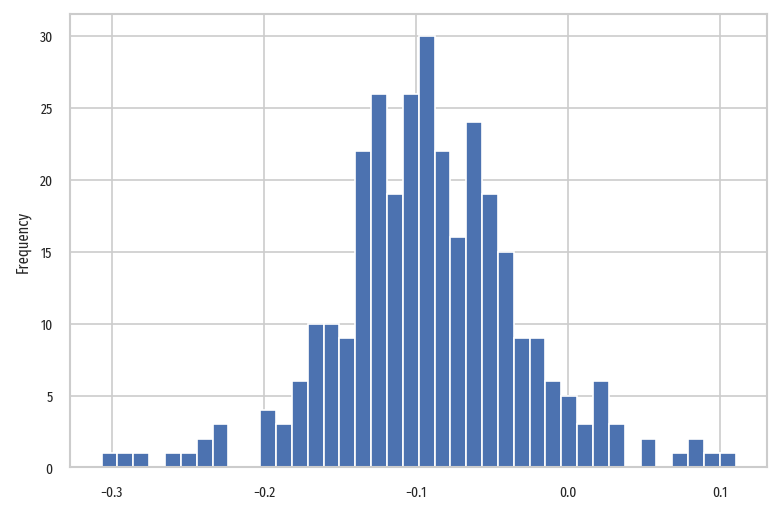

In [181]:
delta_sexo = comunas_x_sexo.pipe(normalize_rows).pipe(
    lambda x: x["Hombre"] - x["Mujer"]
)
delta_sexo.plot(kind="hist", bins=40)


In [182]:
comunas_x_distribucion_sexo = pd.get_dummies(
    pd.qcut(
        delta_sexo,
        q=3,
        labels=[
            "TENDENCIA-HOMBRES",
            "PROPORCIÓN-MEDIA-HOMBRES-MUJERES",
            "TENDENCIA-MUJERES",
        ],
    )
).loc[comunas_index]
comunas_x_distribucion_sexo


,TENDENCIA-HOMBRES,PROPORCIÓN-MEDIA-HOMBRES-MUJERES,TENDENCIA-MUJERES
comuna_nombre,,,
ALGARROBO,1,0,0
ALHUE,1,0,0
ALTO BIOBIO,0,0,1
ALTO DEL CARMEN,0,0,1
ALTO HOSPICIO,0,1,0
...,...,...,...
YUMBEL,0,1,0
YUNGAY,1,0,0
ZAPALLAR,1,0,0


In [183]:
comunas_x_internet = (
    casen_comunas[casen_comunas["edad"] >= 18]
    .groupby(["comuna_nombre", "r21a"])["expr"]
    .sum()
    .unstack(fill_value=0)
    .loc[comunas_index]
)
comunas_x_internet.columns = [
    "Usó redes sociales/Internet para informarse",
    "No usa redes sociales/Internet para informarse",
    "N/A",
]
comunas_x_internet


,Usó redes sociales/Internet para informarse,No usa redes sociales/Internet para informarse,N/A
comuna_nombre,,,
ALGARROBO,5065.0,350.0,128.0
ALHUE,2941.0,143.0,139.0
ALTO BIOBIO,889.0,77.0,0.0
ALTO DEL CARMEN,688.0,66.0,20.0
ALTO HOSPICIO,38777.0,9680.0,490.0
...,...,...,...
YUMBEL,4900.0,570.0,0.0
YUNGAY,10367.0,1377.0,0.0
ZAPALLAR,2563.0,59.0,0.0


In [184]:
delitos = pd.read_csv(
    "../data/external/delitos_cl_2016/Frec_CASOS_POLICIALES_ANUAL_2016.csv"
)
delitos


,ORDEN,UN_ADMIN,REGION,UNIDAD TERRITORIAL,Robo_Violencia,Robo_Sorpresa,Robo_Fuerza,Robo_Vehiculo,Robo_Accesorios_V,Robo_Lugar_Habitado,Robo_Lugar_No_Habitado,Otros_Robos,Hurtos,Lesiones,Lesiones_Leves,Lesiones_Graves,Homicidio,Violación
0,1,REGION,99,PAÍS,65.707,36.412,209.225,29.776,61.586,62.346,49.576,5.941,172.319,75.248,60.001,15.247,495,2.812
1,2,REGION,15,Región de Arica y Parinacota,618.000,451.000,2.154,579.000,549.000,532.000,389.000,105.000,1.762,1.079,733.000,346.000,6,50.000
2,3,PROVINCIA,15,Provincia de Arica,618.000,451.000,2.144,578.000,547.000,529.000,385.000,105.000,1.742,1.070,726.000,344.000,6,49.000
3,4,COMUNA,15,Arica,618.000,451.000,2.135,578.000,546.000,524.000,382.000,105.000,1.735,1.063,720.000,343.000,6,47.000
4,5,COMUNA,15,Camarones,0.000,0.000,9.000,0.000,1.000,5.000,3.000,0.000,7.000,7.000,6.000,1.000,0,2.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,413,COMUNA,13,El Monte,48.000,16.000,251.000,9.000,16.000,111.000,113.000,2.000,99.000,99.000,68.000,31.000,2,1.000
413,414,COMUNA,13,Isla de Maipo,42.000,8.000,215.000,9.000,14.000,109.000,81.000,2.000,92.000,118.000,93.000,25.000,0,2.000
414,415,COMUNA,13,Padre Hurtado,121.000,32.000,373.000,41.000,75.000,182.000,66.000,9.000,169.000,170.000,138.000,32.000,3,7.000
415,416,COMUNA,13,Peñaflor,171.000,103.000,599.000,47.000,104.000,261.000,166.000,21.000,402.000,344.000,264.000,80.000,3,11.000


In [185]:
comunas_x_delitos = (
    delitos[delitos["UN_ADMIN"] == "COMUNA"]
    .assign(
        comuna_nombre=lambda x: x["UNIDAD TERRITORIAL"]
        .str.replace("La Calera", "Calera")
        .str.upper()
        .map(deaccent)
    )
    .set_index("comuna_nombre")
    .drop(["ORDEN", "UN_ADMIN", "REGION", "UNIDAD TERRITORIAL"], axis=1)
    .loc[comunas_index]
)

comunas_x_delitos


,Robo_Violencia,Robo_Sorpresa,Robo_Fuerza,Robo_Vehiculo,Robo_Accesorios_V,Robo_Lugar_Habitado,Robo_Lugar_No_Habitado,Otros_Robos,Hurtos,Lesiones,Lesiones_Leves,Lesiones_Graves,Homicidio,Violación
comuna_nombre,,,,,,,,,,,,,,
ALGARROBO,23.000,11.0,534.000,9.0,56.000,384.0,80.0,5.0,184.000,74.0,52.0,22.0,0,1.0
ALHUE,5.000,2.0,38.000,2.0,1.000,18.0,16.0,1.0,15.000,29.0,26.0,3.0,1,0.0
ALTO BIOBIO,1.000,1.0,11.000,0.0,3.000,1.0,7.0,0.0,18.000,40.0,24.0,16.0,0,3.0
ALTO DEL CARMEN,1.000,0.0,14.000,0.0,1.000,6.0,7.0,0.0,11.000,10.0,8.0,2.0,0,0.0
ALTO HOSPICIO,396.000,222.0,1.580,461.0,338.000,565.0,193.0,23.0,791.000,653.0,523.0,130.0,1,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUMBEL,17.000,2.0,110.000,10.0,8.000,51.0,39.0,2.0,103.000,87.0,67.0,20.0,0,4.0
YUNGAY,14.000,3.0,156.000,1.0,9.000,75.0,55.0,16.0,95.000,76.0,59.0,17.0,0,2.0
ZAPALLAR,4.000,2.0,131.000,3.0,17.000,74.0,35.0,2.0,80.000,27.0,24.0,3.0,0,0.0


In [186]:
plebiscito = pd.read_excel(
    "../data/external/plebiscito_2020/Resultados Plebiscito Constitucion Politica 2020.xlsx",
    sheet_name="Chile",
    engine="openpyxl",
)
plebiscito.head()


,Nro. Región,Región,Provincia,Circ.Senatorial,Distrito,Comuna,Circ.Electoral,Local,Mesa,Tipo mesa,Mesas Fusionadas,Electores,Nro.voto,Opción Constitución Política,Votos TRICEL
0,1.0,DE TARAPACA,IQUIQUE,Circ. Senatorial 2,DISTRITO 2,ALTO HOSPICIO,ALTO HOSPICIO,ANEXO DE COLEGIO SAN ANTONIO DE MATILLA,18.0,M,18M,344.0,1.0,APRUEBO,139.0
1,1.0,DE TARAPACA,IQUIQUE,Circ. Senatorial 2,DISTRITO 2,ALTO HOSPICIO,ALTO HOSPICIO,ANEXO DE COLEGIO SAN ANTONIO DE MATILLA,18.0,M,18M,344.0,2.0,RECHAZO,34.0
2,1.0,DE TARAPACA,IQUIQUE,Circ. Senatorial 2,DISTRITO 2,ALTO HOSPICIO,ALTO HOSPICIO,ANEXO DE COLEGIO SAN ANTONIO DE MATILLA,18.0,M,18M,344.0,900.0,VOTOS NULOS,1.0
3,1.0,DE TARAPACA,IQUIQUE,Circ. Senatorial 2,DISTRITO 2,ALTO HOSPICIO,ALTO HOSPICIO,ANEXO DE COLEGIO SAN ANTONIO DE MATILLA,18.0,M,18M,344.0,901.0,VOTOS EN BLANCO,0.0
4,1.0,DE TARAPACA,IQUIQUE,Circ. Senatorial 2,DISTRITO 2,ALTO HOSPICIO,ALTO HOSPICIO,ANEXO DE COLEGIO SAN ANTONIO DE MATILLA,19.0,M,19M,343.0,1.0,APRUEBO,157.0


In [187]:
plebiscito.columns


Index(['Nro. Región', 'Región', 'Provincia', 'Circ.Senatorial', 'Distrito',
       'Comuna', 'Circ.Electoral', 'Local', 'Mesa', 'Tipo mesa',
       'Mesas Fusionadas', 'Electores', 'Nro.voto',
       'Opción Constitución Política', 'Votos TRICEL'],
      dtype='object')

In [188]:
plebiscito.columns = [
    "region_id",
    "region_nombre",
    "provincia_nombre",
    "circsena_nombre",
    "distrito_nombre",
    "comuna_nombre",
    "circele_nombre",
    "loca_nombre",
    "mesa_id",
    "tipomesa",
    "mesas_fusionadas",
    "electo",
    "nvoto",
    "opcion_constitucion",
    "votos_tricel",
]


In [189]:
plebiscito["comuna_nombre"] = (
    plebiscito["comuna_nombre"].str.strip().fillna("").map(deaccent)
)
plebiscito.iloc[0]


region_id                                                  1.0
region_nombre                                      DE TARAPACA
provincia_nombre                                       IQUIQUE
circsena_nombre                             Circ. Senatorial 2
distrito_nombre                                     DISTRITO 2
comuna_nombre                                    ALTO HOSPICIO
circele_nombre                                   ALTO HOSPICIO
loca_nombre            ANEXO DE COLEGIO SAN ANTONIO DE MATILLA
mesa_id                                                   18.0
tipomesa                                                     M
mesas_fusionadas                                           18M
electo                                                   344.0
nvoto                                                      1.0
opcion_constitucion                                    APRUEBO
votos_tricel                                             139.0
Name: 0, dtype: object

In [190]:
plebiscito.groupby("opcion_constitucion")["votos_tricel"].sum()


opcion_constitucion
APRUEBO            5874352.0
RECHAZO            1628958.0
TOTALES            7542952.0
VOTOS EN BLANCO      12313.0
VOTOS NULOS          27329.0
Name: votos_tricel, dtype: float64

In [191]:
turnout_plebiscito = (
    plebiscito.groupby(["comuna_nombre", "opcion_constitucion"])["votos_tricel"]
    .sum()
    .unstack()
    .loc[comunas_index]
)
turnout_plebiscito.columns = list(map(lambda x: x.strip(), turnout_plebiscito.columns))
turnout_plebiscito.columns
turnout_plebiscito


,APRUEBO,RECHAZO,TOTALES,VOTOS EN BLANCO,VOTOS NULOS
comuna_nombre,,,,,
ALGARROBO,4932.0,2118.0,NaN,13.0,23.0
ALHUE,2323.0,309.0,NaN,1.0,7.0
ALTO BIOBIO,1269.0,424.0,NaN,43.0,69.0
ALTO DEL CARMEN,1559.0,241.0,NaN,8.0,9.0
ALTO HOSPICIO,21589.0,4534.0,NaN,37.0,98.0
...,...,...,...,...,...
YUMBEL,5246.0,2149.0,NaN,25.0,56.0
YUNGAY,5262.0,1584.0,NaN,16.0,29.0
ZAPALLAR,3250.0,1643.0,NaN,3.0,13.0


In [192]:
constitucion = [
    "APRUEBO",
    "RECHAZO",
]
columnas_votos_plebiscito = constitucion + ["VOTOS EN BLANCO", "VOTOS NULOS"]
total_votos_plebiscito = turnout_plebiscito[columnas_votos_plebiscito].sum(axis=1)
total_votos_plebiscito


comuna_nombre
ALGARROBO            7086.0
ALHUE                2640.0
ALTO BIOBIO          1805.0
ALTO DEL CARMEN      1817.0
ALTO HOSPICIO       26258.0
                     ...   
YUMBEL               7476.0
YUNGAY               6891.0
ZAPALLAR             4909.0
NIQUEN               3259.0
NUNOA              125508.0
Length: 319, dtype: float64

In [193]:
abstencion_plebiscito = (poblacion_comunas - total_votos_plebiscito).rename(
    "Abstención-Plebiscito"
)
abstencion_plebiscito


comuna_nombre
ALGARROBO           5384.0
ALHUE               2704.0
ALTO BIOBIO         1972.0
ALTO DEL CARMEN     3491.0
ALTO HOSPICIO      69620.0
                    ...   
VITACURA           -6051.0
YERBAS BUENAS       7059.0
YUMBEL              7949.0
YUNGAY             10356.0
ZAPALLAR            1859.0
Name: Abstención-Plebiscito, Length: 324, dtype: float64

In [194]:
total_votos_plebiscito = turnout_plebiscito.sum(axis=1)
abstencion_plebiscito = (poblacion_comunas - total_votos_plebiscito).rename(
    "Abstención-Plebiscito"
)
turnout_plebiscito = turnout_plebiscito.join(abstencion_plebiscito, how="left")[
    columnas_votos_plebiscito + ["Abstención-Plebiscito"]
]
turnout_plebiscito


,APRUEBO,RECHAZO,VOTOS EN BLANCO,VOTOS NULOS,Abstención-Plebiscito
comuna_nombre,,,,,
ALGARROBO,4932.0,2118.0,13.0,23.0,5384.0
ALHUE,2323.0,309.0,1.0,7.0,2704.0
ALTO BIOBIO,1269.0,424.0,43.0,69.0,1972.0
ALTO DEL CARMEN,1559.0,241.0,8.0,9.0,3491.0
ALTO HOSPICIO,21589.0,4534.0,37.0,98.0,69620.0
...,...,...,...,...,...
YUMBEL,5246.0,2149.0,25.0,56.0,7949.0
YUNGAY,5262.0,1584.0,16.0,29.0,10356.0
ZAPALLAR,3250.0,1643.0,3.0,13.0,1859.0


In [195]:
diff_abstencion = turnout["Abstención"] - turnout_plebiscito["Abstención-Plebiscito"]
diff_abstencion.describe()


count      319.000000
mean      1459.059561
std       5094.215934
min      -5160.000000
25%       -752.500000
50%       -122.000000
75%       1227.500000
max      39998.000000
dtype: float64

In [196]:
abstencion_plebiscito_cat = pd.qcut(turnout_plebiscito.pipe(normalize_rows)['Abstención-Plebiscito'], q=4, labels=['ALTA-VOTACIÓN', 'VOTACIÓN-MODERADA', 'ABSTENCIÓN-MODERADA', 
'ALTA-ABSTENCIÓN'])
abstencion_plebiscito_cat = pd.get_dummies(abstencion_plebiscito_cat).loc[comunas_index]
abstencion_plebiscito_cat

,ALTA-VOTACIÓN,VOTACIÓN-MODERADA,ABSTENCIÓN-MODERADA,ALTA-ABSTENCIÓN
comuna_nombre,,,,
ALGARROBO,0,1,0,0
ALHUE,0,1,0,0
ALTO BIOBIO,0,0,1,0
ALTO DEL CARMEN,0,0,0,1
ALTO HOSPICIO,0,0,0,1
...,...,...,...,...
YUMBEL,0,0,1,0
YUNGAY,0,0,0,1
ZAPALLAR,1,0,0,0


In [197]:
diff_abstencion


comuna_nombre
ALGARROBO         -1131.0
ALHUE               123.0
ALTO BIOBIO        -203.0
ALTO DEL CARMEN    -147.0
ALTO HOSPICIO      1689.0
                    ...  
VITACURA          -1421.0
YERBAS BUENAS      -835.0
YUMBEL            -1295.0
YUNGAY               28.0
ZAPALLAR           -552.0
Length: 346, dtype: float64

In [198]:
turnout["Abstención"].sum(), turnout_plebiscito["Abstención-Plebiscito"].sum()


(8267842.0, 7767359.0)

In [199]:
elecciones

,eleccion_id,eleccion_nombre,region_id,region_nombre,provincia_id,provincia_nombre,comuna_id,comuna_nombre,circele_id,circele_nombre,...,sede_colegio,cs_id,cs,distrito_id,distrito,lista,pacto,partido_politico,location_name,votos_preliminar_string_strip
0,4,Elección de Presidente 2021 ...,3001,DE TARAPACA,4011,IQUIQUE ...,2501,IQUIQUE,7007,IQUIQUE ...,...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,CONVERGENCIA SOCIAL ...,LICEO LUIS CRUZ MARTINEZ,11
1,4,Elección de Presidente 2021 ...,3001,DE TARAPACA,4011,IQUIQUE ...,2501,IQUIQUE,7007,IQUIQUE ...,...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,PARTIDO REPUBLICANO DE CHILE ...,LICEO LUIS CRUZ MARTINEZ,32
2,4,Elección de Presidente 2021 ...,3001,DE TARAPACA,4011,IQUIQUE ...,2501,IQUIQUE,7007,IQUIQUE ...,...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,PARTIDO DEMOCRATA CRISTIANO ...,LICEO LUIS CRUZ MARTINEZ,5
3,4,Elección de Presidente 2021 ...,3001,DE TARAPACA,4011,IQUIQUE ...,2501,IQUIQUE,7007,IQUIQUE ...,...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,EVOLUCION POLITICA ...,LICEO LUIS CRUZ MARTINEZ,10
4,4,Elección de Presidente 2021 ...,3001,DE TARAPACA,4011,IQUIQUE ...,2501,IQUIQUE,7007,IQUIQUE ...,...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,UNION PATRIOTICA ...,LICEO LUIS CRUZ MARTINEZ,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513024,4,Elección de Presidente 2021 ...,3016,DE ÑUBLE,4163,PUNILLA ...,2846,SAN NICOLAS,7642,PUENTE ÑUBLE ...,...,DAVID GAZMURI NÚMERO 451 ...,5016,CIRCUNSCRIPCIÓN SENATORIAL 16 ...,6019,DISTRITO 19 ...,...,SIN PACTO ...,PARTIDO DE LA GENTE ...,LICEO TECNICO PUENTE ÑUBLE,33
513025,4,Elección de Presidente 2021 ...,3016,DE ÑUBLE,4163,PUNILLA ...,2846,SAN NICOLAS,7642,PUENTE ÑUBLE ...,...,DAVID GAZMURI NÚMERO 451 ...,5016,CIRCUNSCRIPCIÓN SENATORIAL 16 ...,6019,DISTRITO 19 ...,...,...,...,LICEO TECNICO PUENTE ÑUBLE,2
513026,4,Elección de Presidente 2021 ...,3016,DE ÑUBLE,4163,PUNILLA ...,2846,SAN NICOLAS,7642,PUENTE ÑUBLE ...,...,DAVID GAZMURI NÚMERO 451 ...,5016,CIRCUNSCRIPCIÓN SENATORIAL 16 ...,6019,DISTRITO 19 ...,...,...,...,LICEO TECNICO PUENTE ÑUBLE,2
513027,4,Elección de Presidente 2021 ...,3016,DE ÑUBLE,4163,PUNILLA ...,2846,SAN NICOLAS,7642,PUENTE ÑUBLE ...,...,DAVID GAZMURI NÚMERO 451 ...,5016,CIRCUNSCRIPCIÓN SENATORIAL 16 ...,6019,DISTRITO 19 ...,...,...,...,LICEO TECNICO PUENTE ÑUBLE,169


In [200]:
vec_a = (
    pd.qcut(
        diff_abstencion.dropna(),
        q=3,
        labels=["Mayor Votación", "Mantiene Votación", "Disminuye Votación"],
    ).astype(str)
    + "\nRespecto a Plebiscito"
)
vec_a


comuna_nombre
ALGARROBO              Mayor Votación\nRespecto a Plebiscito
ALHUE               Mantiene Votación\nRespecto a Plebiscito
ALTO BIOBIO         Mantiene Votación\nRespecto a Plebiscito
ALTO DEL CARMEN     Mantiene Votación\nRespecto a Plebiscito
ALTO HOSPICIO      Disminuye Votación\nRespecto a Plebiscito
                                     ...                    
VITACURA               Mayor Votación\nRespecto a Plebiscito
YERBAS BUENAS          Mayor Votación\nRespecto a Plebiscito
YUMBEL                 Mayor Votación\nRespecto a Plebiscito
YUNGAY              Mantiene Votación\nRespecto a Plebiscito
ZAPALLAR               Mayor Votación\nRespecto a Plebiscito
Length: 319, dtype: object

In [201]:
vec_a.sample(10)


comuna_nombre
CONCON               Mayor Votación\nRespecto a Plebiscito
VILLA ALEMANA    Disminuye Votación\nRespecto a Plebiscito
LLAILLAY         Disminuye Votación\nRespecto a Plebiscito
LOLOL                Mayor Votación\nRespecto a Plebiscito
RENGO            Disminuye Votación\nRespecto a Plebiscito
SAN CARLOS           Mayor Votación\nRespecto a Plebiscito
PUYEHUE           Mantiene Votación\nRespecto a Plebiscito
TILTIL           Disminuye Votación\nRespecto a Plebiscito
PURRANQUE            Mayor Votación\nRespecto a Plebiscito
TOME              Mantiene Votación\nRespecto a Plebiscito
dtype: object

In [202]:
comunas_x_delta_abs = pd.get_dummies(vec_a).loc[comunas_index]
comunas_x_delta_abs


,Disminuye Votación\nRespecto a Plebiscito,Mantiene Votación\nRespecto a Plebiscito,Mayor Votación\nRespecto a Plebiscito
comuna_nombre,,,
ALGARROBO,0,0,1
ALHUE,0,1,0
ALTO BIOBIO,0,1,0
ALTO DEL CARMEN,0,1,0
ALTO HOSPICIO,1,0,0
...,...,...,...
YUMBEL,0,0,1
YUNGAY,0,1,0
ZAPALLAR,0,0,1


In [203]:
diff_abstencion.loc[
    ["VITACURA", "NUNOA", "CONCEPCION", "PUENTE ALTO", "LO PRADO", "SANTIAGO"]
]


comuna_nombre
VITACURA       -1421.0
NUNOA           2507.0
CONCEPCION      5581.0
PUENTE ALTO    39998.0
LO PRADO       10995.0
SANTIAGO       13483.0
dtype: float64

In [204]:
comunas_x_delta_abs.loc[
    ["VITACURA", "NUNOA", "CONCEPCION", "PUENTE ALTO", "LO PRADO", "SANTIAGO"]
]


,Disminuye Votación\nRespecto a Plebiscito,Mantiene Votación\nRespecto a Plebiscito,Mayor Votación\nRespecto a Plebiscito
comuna_nombre,,,
VITACURA,0,0,1
NUNOA,1,0,0
CONCEPCION,1,0,0
PUENTE ALTO,1,0,0
LO PRADO,1,0,0
SANTIAGO,1,0,0


In [205]:
candidatos_x_plebiscito = pd.read_csv('../data/external/tweet_voter_matrix.csv', index_col=0)
candidatos_x_plebiscito

,APRUEBO,RECHAZO,VOTOS EN BLANCO,VOTOS NULOS
EDUARDO ARTES BRICHETTI,0.950743,0.048327,0.000929,0.000929
GABRIEL BORIC FONT,0.963622,0.034835,0.001544,0.001544
JOSE ANTONIO KAST RIST,0.377370,0.619299,0.003332,0.003332
MARCO ENRIQUEZ-OMINAMI GUMUCIO,0.898305,0.100282,0.001412,0.001412
FRANCO PARISI FERNANDEZ,0.863187,0.133753,0.003060,0.003060
YASNA PROVOSTE CAMPILLAY,0.923271,0.073448,0.003281,0.003281
SEBASTIAN SICHEL RAMIREZ,0.475607,0.520455,0.003938,0.003938
Votos Blancos,0.909492,0.086093,0.004415,0.004415
Votos Nulos,0.909492,0.086093,0.004415,0.004415


In [206]:
candidatos_x_plebiscito.loc[turnout.drop("Abstención", axis=1).columns]

,APRUEBO,RECHAZO,VOTOS EN BLANCO,VOTOS NULOS
EDUARDO ARTES BRICHETTI,0.950743,0.048327,0.000929,0.000929
GABRIEL BORIC FONT,0.963622,0.034835,0.001544,0.001544
JOSE ANTONIO KAST RIST,0.377370,0.619299,0.003332,0.003332
MARCO ENRIQUEZ-OMINAMI GUMUCIO,0.898305,0.100282,0.001412,0.001412
FRANCO PARISI FERNANDEZ,0.863187,0.133753,0.003060,0.003060
YASNA PROVOSTE CAMPILLAY,0.923271,0.073448,0.003281,0.003281
SEBASTIAN SICHEL RAMIREZ,0.475607,0.520455,0.003938,0.003938
Votos Blancos,0.909492,0.086093,0.004415,0.004415
Votos Nulos,0.909492,0.086093,0.004415,0.004415


## Focalización Geográfica

In [401]:
import geopandas as gpd
grid = gpd.read_file('../data/interim/scl-census-grid/scl-boundary-grid.geo.json').to_crs('epsg:4326')
grid

,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,SHAPE_Leng,SHAPE_Area,s2_cellid,area_weight,geometry
0,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13402,BUIN,0.884164,0.021166,10836461268177518592,208016.974474,"POLYGON ((-70.63231 -33.64724, -70.63250 -33.6..."
1,13,REGIÓN METROPOLITANA DE SANTIAGO,132,CORDILLERA,13201,PUENTE ALTO,0.497638,0.008573,10836461268177518592,1714.522585,"POLYGON ((-70.62203 -33.64363, -70.62295 -33.6..."
2,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13401,SAN BERNARDO,0.852814,0.014857,10836461268177518592,232249.084050,"POLYGON ((-70.63033 -33.63657, -70.63035 -33.6..."
3,13,REGIÓN METROPOLITANA DE SANTIAGO,132,CORDILLERA,13202,PIRQUE,1.029066,0.043323,10836461268177518592,21167.070803,"POLYGON ((-70.63231 -33.64724, -70.63207 -33.6..."
4,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13402,BUIN,0.884164,0.021166,10836461680494379008,317872.819618,"POLYGON ((-70.66886 -33.65788, -70.66712 -33.6..."
...,...,...,...,...,...,...,...,...,...,...,...
1219,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13101,SANTIAGO,0.243050,0.002244,10836440343096852480,28138.530267,"POLYGON ((-70.64547 -33.45583, -70.64547 -33.4..."
1220,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13101,SANTIAGO,0.243050,0.002244,10836440377456590848,8872.912504,"POLYGON ((-70.65737 -33.45776, -70.65737 -33.4..."
1221,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13101,SANTIAGO,0.243050,0.002244,10836440721053974528,131569.094156,"POLYGON ((-70.63358 -33.45391, -70.63358 -33.4..."
1222,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13101,SANTIAGO,0.243050,0.002244,10836440961572143104,848556.024732,"POLYGON ((-70.64547 -33.43426, -70.64547 -33.4..."


In [402]:
grid['NOM_COMUNA'] = grid['NOM_COMUNA'].map(deaccent)

In [424]:
locations_in_grid = gpd.read_file('../data/interim/scl-census-grid/scl-geolocated-voting-locations.geo.json')
locations_in_grid

,location,s2_cellid,geometry
0,LICEO JAVIERA CARRERA,10836440995931881472,POINT (-70.65742 -33.43936)
1,INACAP SANTIAGO CENTRO,10836440995931881472,POINT (-70.66231 -33.44352)
2,LICEO DE APLICACION RECTOR JORGE E SCHNE 29,10836440995931881472,POINT (-70.66721 -33.44648)
3,LICEO DE APLICACION RECTOR JORGE E SCHNE 21,10836440995931881472,POINT (-70.66721 -33.44648)
4,COLEGIO PEDRO DE VALDIVIA,10836440995931881472,POINT (-70.66452 -33.44198)
...,...,...,...
388,COLEGIO POLIVALENTE SAN AGUSTIN,10836465356986384384,POINT (-70.68001 -33.56993)
389,COLEGIO ALONSO DE ERCILLA,10836453331077955584,POINT (-70.58296 -33.53410)
390,ESCUELA BRASILIA,10836467246771994624,POINT (-70.81063 -33.56914)
391,LICEO COMERCIAL REPUBLICA DE BRASIL,10836477829571411968,POINT (-70.85295 -33.60227)


In [425]:
elecciones_region = elecciones[elecciones['region_nombre'] == 'METROPOLITANA DE SANTIAGO'].copy()

In [426]:
elecciones_geoloc = elecciones_region.join(
    locations_in_grid.set_index("location")["s2_cellid"],
    on="location_name",
    how="inner",
).dropna()
elecciones_geoloc.head()

,eleccion_id,eleccion_nombre,region_id,region_nombre,provincia_id,provincia_nombre,comuna_id,comuna_nombre,circele_id,circele_nombre,...,cs_id,cs,distrito_id,distrito,lista,pacto,partido_politico,location_name,votos_preliminar_string_strip,s2_cellid
279796,4,Elección de Presidente 2021 ...,3013,METROPOLITANA DE SANTIAGO,4131,SANTIAGO ...,2758,SANTIAGO,7128,EL CENTRO ...,...,5007,CIRCUNSCRIPCIÓN SENATORIAL 7 ...,6010,DISTRITO 10 ...,...,SIN PACTO ...,CONVERGENCIA SOCIAL ...,LICEO JAVIERA CARRERA,32,10836440995931881472
279797,4,Elección de Presidente 2021 ...,3013,METROPOLITANA DE SANTIAGO,4131,SANTIAGO ...,2758,SANTIAGO,7128,EL CENTRO ...,...,5007,CIRCUNSCRIPCIÓN SENATORIAL 7 ...,6010,DISTRITO 10 ...,...,SIN PACTO ...,PARTIDO REPUBLICANO DE CHILE ...,LICEO JAVIERA CARRERA,18,10836440995931881472
279798,4,Elección de Presidente 2021 ...,3013,METROPOLITANA DE SANTIAGO,4131,SANTIAGO ...,2758,SANTIAGO,7128,EL CENTRO ...,...,5007,CIRCUNSCRIPCIÓN SENATORIAL 7 ...,6010,DISTRITO 10 ...,...,SIN PACTO ...,PARTIDO DEMOCRATA CRISTIANO ...,LICEO JAVIERA CARRERA,5,10836440995931881472
279799,4,Elección de Presidente 2021 ...,3013,METROPOLITANA DE SANTIAGO,4131,SANTIAGO ...,2758,SANTIAGO,7128,EL CENTRO ...,...,5007,CIRCUNSCRIPCIÓN SENATORIAL 7 ...,6010,DISTRITO 10 ...,...,SIN PACTO ...,EVOLUCION POLITICA ...,LICEO JAVIERA CARRERA,12,10836440995931881472
279800,4,Elección de Presidente 2021 ...,3013,METROPOLITANA DE SANTIAGO,4131,SANTIAGO ...,2758,SANTIAGO,7128,EL CENTRO ...,...,5007,CIRCUNSCRIPCIÓN SENATORIAL 7 ...,6010,DISTRITO 10 ...,...,SIN PACTO ...,UNION PATRIOTICA ...,LICEO JAVIERA CARRERA,1,10836440995931881472


In [427]:
turnout_geoloc = (
    elecciones_geoloc.groupby(["s2_cellid", "candidato"])[
        "votos_preliminar_string_strip"
    ]
    .sum()
    .unstack()
)
turnout_geoloc.columns = list(map(lambda x: x.strip(), turnout_geoloc.columns))
turnout_geoloc = turnout_geoloc[turnout.columns[:-1]].pipe(normalize_rows)
turnout_geoloc.head()


,EDUARDO ARTES BRICHETTI,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,MARCO ENRIQUEZ-OMINAMI GUMUCIO,FRANCO PARISI FERNANDEZ,YASNA PROVOSTE CAMPILLAY,SEBASTIAN SICHEL RAMIREZ,Votos Blancos,Votos Nulos
s2_cellid,,,,,,,,,
10836426667920982016,0.012352,0.258324,0.320623,0.081633,0.117615,0.069280,0.133727,0.002685,0.003759
10836434089624469504,0.012410,0.320234,0.248363,0.086005,0.099966,0.063426,0.163392,0.001551,0.004654
10836435567093219328,0.014297,0.303459,0.238125,0.087779,0.064566,0.114527,0.167717,0.002152,0.007379
10836435601452957696,0.018900,0.324055,0.204553,0.108076,0.104811,0.115636,0.111168,0.002663,0.010137
10836435635812696064,0.031122,0.399111,0.121751,0.104651,0.180575,0.060534,0.093707,0.001368,0.007182


<AxesSubplot:>

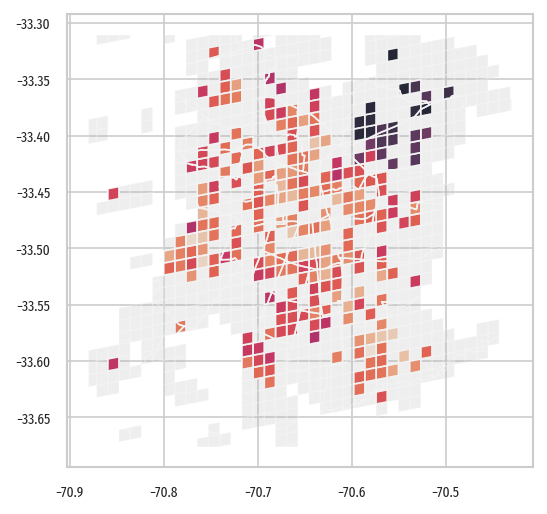

In [428]:
ax = grid.join(turnout_geoloc["GABRIEL BORIC FONT"], on="s2_cellid", how="inner").plot(
    column="GABRIEL BORIC FONT"
)
grid.plot(facecolor="#abacab", alpha=0.2, ax=ax)


In [429]:
grid_x_comuna = pd.pivot_table(grid, index='s2_cellid', columns='NOM_COMUNA', values='area_weight').pipe(normalize_rows).fillna(0)
grid_x_comuna

NOM_COMUNA,BUIN,CALERA DE TANGO,CERRILLOS,CERRO NAVIA,COLINA,CONCHALI,EL BOSQUE,ESTACION CENTRAL,HUECHURABA,INDEPENDENCIA,...,RECOLETA,RENCA,SAN BERNARDO,SAN JOAQUIN,SAN JOSE DE MAIPO,SAN MIGUEL,SAN RAMON,SANTIAGO,TALAGANTE,VITACURA
s2_cellid,,,,,,,,,,,,,,,,,,,,,
10836387463459504128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10836387497819242496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10836387532178980864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10836426015085953024,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10836426461762551808,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836548507553234944,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10836548541912973312,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10836548576272711680,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [430]:
print(len(grid_x_comuna.columns), len(set(grid_x_comuna.columns) & set(comunas_index)))
geoloc_comunas_index = grid_x_comuna.columns

43 43


In [431]:
from aves.models.datafusion import ensure_index, ensure_columns

In [432]:
grid_x_age = (
    pd.read_csv(
        "../data/interim/scl-census-grid/scl-census-age-grid.csv",
        dtype={"s2_cellid": "str"},
    )
    .set_index("s2_cellid")
    .pipe(normalize_rows)
    .pipe(lambda x: ensure_index(x, grid_x_comuna.index))
)
grid_x_age.columns = comunas_x_edad.columns
grid_x_age


grupo_etareo,18-25,26-35,36-45,46-55,56-65,66-75,75+
10836387463459504128,0.182729,0.211832,0.195134,0.197996,0.110687,0.068225,0.033397
10836387497819242496,0.182729,0.211832,0.195134,0.197996,0.110687,0.068225,0.033397
10836387532178980864,0.182729,0.211832,0.195134,0.197996,0.110687,0.068225,0.033397
10836426015085953024,0.051537,0.289736,0.461239,0.118233,0.038545,0.031182,0.009528
10836426461762551808,0.100513,0.201499,0.413737,0.177396,0.057615,0.036748,0.012491
...,...,...,...,...,...,...,...
10836548507553234944,0.183624,0.220349,0.192053,0.179410,0.128236,0.062011,0.034317
10836548541912973312,0.183624,0.220349,0.192053,0.179410,0.128236,0.062011,0.034317
10836548576272711680,0.183624,0.220349,0.192053,0.179410,0.128236,0.062011,0.034317
10836548679351926784,0.183624,0.220349,0.192053,0.179410,0.128236,0.062011,0.034317


In [433]:
grid_x_income = (
    pd.read_csv(
        "../data/interim/scl-census-grid/scl-census-income-grid.csv",
        dtype={"s2_cellid": "str"},
    )
    .set_index("s2_cellid")
    .pipe(normalize_rows)
    .pipe(lambda x: ensure_index(x, grid_x_comuna.index))
)
grid_x_income.columns = comunas_x_ingreso.columns
grid_x_income


dautr,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
10836387463459504128,0.057329,0.0,0.013593,0.060875,0.063830,0.110520,0.231087,0.354610,0.105792,0.002364
10836387497819242496,0.057329,0.0,0.013593,0.060875,0.063830,0.110520,0.231087,0.354610,0.105792,0.002364
10836387532178980864,0.057329,0.0,0.013593,0.060875,0.063830,0.110520,0.231087,0.354610,0.105792,0.002364
10836426015085953024,0.002303,0.0,0.001842,0.001382,0.003685,0.007830,0.017964,0.085675,0.631046,0.248273
10836426461762551808,0.003276,0.0,0.001586,0.003867,0.005218,0.008396,0.026807,0.098123,0.637045,0.215682
...,...,...,...,...,...,...,...,...,...,...
10836548507553234944,0.030172,0.0,0.011494,0.051724,0.111351,0.136494,0.244253,0.290948,0.117816,0.005747
10836548541912973312,0.030172,0.0,0.011494,0.051724,0.111351,0.136494,0.244253,0.290948,0.117816,0.005747
10836548576272711680,0.030172,0.0,0.011494,0.051724,0.111351,0.136494,0.244253,0.290948,0.117816,0.005747
10836548679351926784,0.030172,0.0,0.011494,0.051724,0.111351,0.136494,0.244253,0.290948,0.117816,0.005747


In [434]:
cells_with_data = set(turnout_geoloc.index)
len(cells_with_data)

239

In [435]:
cells_for_imputation = []
seen_cells = set()

for idx, row in turnout.loc[geoloc_comunas_index].iterrows():
    cells = set(grid[grid["NOM_COMUNA"] == idx]["s2_cellid"])
    cells_without_data = cells - cells_with_data

    for cell_id in cells_without_data:
        if cell_id in seen_cells:
            continue
        cells_for_imputation.append(row.rename(cell_id))
        seen_cells.add(cell_id)

cells_for_imputation = (
    pd.DataFrame(cells_for_imputation).drop("Abstención", axis=1).pipe(normalize_rows)
)
cells_for_imputation


,EDUARDO ARTES BRICHETTI,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,MARCO ENRIQUEZ-OMINAMI GUMUCIO,FRANCO PARISI FERNANDEZ,YASNA PROVOSTE CAMPILLAY,SEBASTIAN SICHEL RAMIREZ,Votos Blancos,Votos Nulos
10836548507553234944,0.012788,0.261741,0.290059,0.079744,0.130546,0.094950,0.114892,0.003290,0.011990
10836548541912973312,0.012788,0.261741,0.290059,0.079744,0.130546,0.094950,0.114892,0.003290,0.011990
10836548576272711680,0.012788,0.261741,0.290059,0.079744,0.130546,0.094950,0.114892,0.003290,0.011990
10836461268177518592,0.012788,0.261741,0.290059,0.079744,0.130546,0.094950,0.114892,0.003290,0.011990
10836461680494379008,0.012788,0.261741,0.290059,0.079744,0.130546,0.094950,0.114892,0.003290,0.011990
...,...,...,...,...,...,...,...,...,...
10836444534984933376,0.001781,0.072604,0.507207,0.007288,0.004130,0.058498,0.339633,0.001765,0.007094
10836444844222578688,0.001781,0.072604,0.507207,0.007288,0.004130,0.058498,0.339633,0.001765,0.007094
10836444397545979904,0.001781,0.072604,0.507207,0.007288,0.004130,0.058498,0.339633,0.001765,0.007094
10836444981661532160,0.001781,0.072604,0.507207,0.007288,0.004130,0.058498,0.339633,0.001765,0.007094


In [436]:
len(pd.concat([turnout_geoloc, cells_for_imputation]))

797

In [438]:
all_cells_turnout = pd.concat([turnout_geoloc, cells_for_imputation]).pipe(
    lambda x: ensure_index(x, grid_x_comuna.index)
)
all_cells_turnout


,EDUARDO ARTES BRICHETTI,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,MARCO ENRIQUEZ-OMINAMI GUMUCIO,FRANCO PARISI FERNANDEZ,YASNA PROVOSTE CAMPILLAY,SEBASTIAN SICHEL RAMIREZ,Votos Blancos,Votos Nulos
10836387463459504128,0.015658,0.253863,0.250944,0.110535,0.136838,0.094499,0.126228,0.004155,0.007280
10836387497819242496,0.015658,0.253863,0.250944,0.110535,0.136838,0.094499,0.126228,0.004155,0.007280
10836387532178980864,0.015658,0.253863,0.250944,0.110535,0.136838,0.094499,0.126228,0.004155,0.007280
10836426015085953024,0.008180,0.169291,0.384367,0.063973,0.084879,0.074829,0.204411,0.003761,0.006310
10836426461762551808,0.008180,0.169291,0.384367,0.063973,0.084879,0.074829,0.204411,0.003761,0.006310
...,...,...,...,...,...,...,...,...,...
10836548507553234944,0.012788,0.261741,0.290059,0.079744,0.130546,0.094950,0.114892,0.003290,0.011990
10836548541912973312,0.012788,0.261741,0.290059,0.079744,0.130546,0.094950,0.114892,0.003290,0.011990
10836548576272711680,0.012788,0.261741,0.290059,0.079744,0.130546,0.094950,0.114892,0.003290,0.011990
10836548679351926784,0.012788,0.261741,0.290059,0.079744,0.130546,0.094950,0.114892,0.003290,0.011990


## Modelo de Fusión de Datos

In [439]:
from aves.features.utils import tfidf as aves_tfidf

# dimensión (rank) de la representación latente de cada entidad
model_nodes = {
    "candidatos": 12,
    "comunas": 32,
    "grupo_etareo": 6,
    "ingreso": 6,
    "celular": 2,
    "oficio": 8,
    "trabajo": 8,
    "retiro": 2,
    "origen": 2,
    "migrantes": 8,
    "hogar": 4,
    "narcotráfico": 3,
    "estado_civil": 4,
    "area": 2,
    "delincuencia": 4,
    "internet_inf": 2,
    "plebiscito": 3,
    "abstencion": 3,
    "sexo": 2,
    "abstencion_plebiscito": 3,
    "grid": 128,
}

# relaciones entre entidades
# normalizamos todo
model_relations = {
    # quitamos la abstención
    ("candidatos", "comunas"): [
        turnout.drop("Abstención", axis=1)
        .fillna(0)
        .pipe(lambda x: aves_tfidf(x, norm="l1", smooth_idf=True))
        .T[geoloc_comunas_index]
    ],
    # ("programa", "candidatos"): [weighted_dtm_df.drop("Abstención").T],
    ("comunas", "plebiscito"): [
        turnout_plebiscito.drop("Abstención-Plebiscito", axis=1)
        .fillna(0)
        .pipe(lambda x: aves_tfidf(x, norm="l1", smooth_idf=True))
        .loc[geoloc_comunas_index]
    ],
    ("plebiscito", "comunas"): [
        turnout_plebiscito.drop("Abstención-Plebiscito", axis=1)
        .loc[geoloc_comunas_index]
        .T.fillna(0)
        .pipe(lambda x: aves_tfidf(x, norm="l1", smooth_idf=True))
    ],
    ("candidatos", "plebiscito"): [candidatos_x_plebiscito.pipe(normalize_rows)],
    ("comunas", "grupo_etareo"): [
        comunas_x_edad.pipe(normalize_rows).loc[geoloc_comunas_index]
    ],
    ("comunas", "ingreso"): [
        comunas_x_ingreso.pipe(normalize_rows).loc[geoloc_comunas_index]
    ],
    ("comunas", "celular"): [
        comunas_x_moviles.pipe(normalize_rows).loc[geoloc_comunas_index]
    ],
    ("comunas", "oficio"): [
        comunas_x_oficio.pipe(normalize_rows).loc[geoloc_comunas_index]
    ],
    ("comunas", "trabajo"): [
        comunas_x_trabajo.pipe(normalize_rows).loc[geoloc_comunas_index]
    ],
    ("comunas", "retiro"): [
        comunas_x_retiro.pipe(normalize_rows).loc[geoloc_comunas_index]
    ],
    ("comunas", "origen"): [
        comunas_x_origen.pipe(normalize_rows).loc[geoloc_comunas_index]
    ],
    ("comunas", "migrantes"): [
        comunas_x_migrantes.pipe(normalize_rows).loc[geoloc_comunas_index]
    ],
    ("comunas", "hogar"): [
        comunas_x_tipo_hogar.pipe(normalize_rows).loc[geoloc_comunas_index]
    ],
    ("comunas", "narcotráfico"): [
        comunas_x_drogas.pipe(normalize_rows).loc[geoloc_comunas_index]
    ],
    ("comunas", "estado_civil"): [
        comunas_x_estado_civil.pipe(normalize_rows).loc[geoloc_comunas_index]
    ],
    ("comunas", "area"): [
        comunas_x_area.pipe(normalize_rows).loc[geoloc_comunas_index]
    ],
    ("comunas", "delincuencia"): [
        comunas_x_delitos.pipe(normalize_rows).loc[geoloc_comunas_index]
    ],
    ("comunas", "internet_inf"): [
        comunas_x_internet.pipe(normalize_rows).loc[geoloc_comunas_index]
    ],
    ("abstencion", "comunas"): [comunas_x_delta_abs.loc[geoloc_comunas_index].T],
    ("abstencion_plebiscito", "comunas"): [
        abstencion_plebiscito_cat.loc[geoloc_comunas_index].T
    ],
    ("comunas", "abstencion"): [comunas_x_delta_abs.loc[geoloc_comunas_index]],
    # ("comunas", "región"): [comunas_x_region.loc[comunas_index]],
    ("comunas", "sexo"): [comunas_x_distribucion_sexo.loc[geoloc_comunas_index]],
    # usa solamente con datos en celda
    # ("comunas", "grid"): [grid_x_comuna.loc[turnout_geoloc.index].T],
    # ("grid", "grupo_etareo"): [grid_x_age.loc[turnout_geoloc.index]],
    # ("grid", "ingreso"): [grid_x_income.loc[turnout_geoloc.index]],
    # ("grid", "candidatos"): [turnout_geoloc]
    # usa con imputación
    ("comunas", "grid"): [grid_x_comuna.T],
    ("grid", "grupo_etareo"): [grid_x_age],
    ("grid", "ingreso"): [grid_x_income],
    ("grid", "candidatos"): [all_cells_turnout],
}

model = DataFusionModel(nodes=model_nodes, relations=model_relations)
model.fit()


{'candidatos': ObjectType("candidatos"), 'comunas': ObjectType("comunas"), 'grupo_etareo': ObjectType("grupo_etareo"), 'ingreso': ObjectType("ingreso"), 'celular': ObjectType("celular"), 'oficio': ObjectType("oficio"), 'trabajo': ObjectType("trabajo"), 'retiro': ObjectType("retiro"), 'origen': ObjectType("origen"), 'migrantes': ObjectType("migrantes"), 'hogar': ObjectType("hogar"), 'narcotráfico': ObjectType("narcotráfico"), 'estado_civil': ObjectType("estado_civil"), 'area': ObjectType("area"), 'delincuencia': ObjectType("delincuencia"), 'internet_inf': ObjectType("internet_inf"), 'plebiscito': ObjectType("plebiscito"), 'abstencion': ObjectType("abstencion"), 'sexo': ObjectType("sexo"), 'abstencion_plebiscito': ObjectType("abstencion_plebiscito"), 'grid': ObjectType("grid")}
[Relation(ObjectType("candidatos") → ObjectType("comunas")), Relation(ObjectType("comunas") → ObjectType("plebiscito")), Relation(ObjectType("plebiscito") → ObjectType("comunas")), Relation(ObjectType("candidatos"

Text(0.5, 1.0, 'Reconstrucción del modelo')

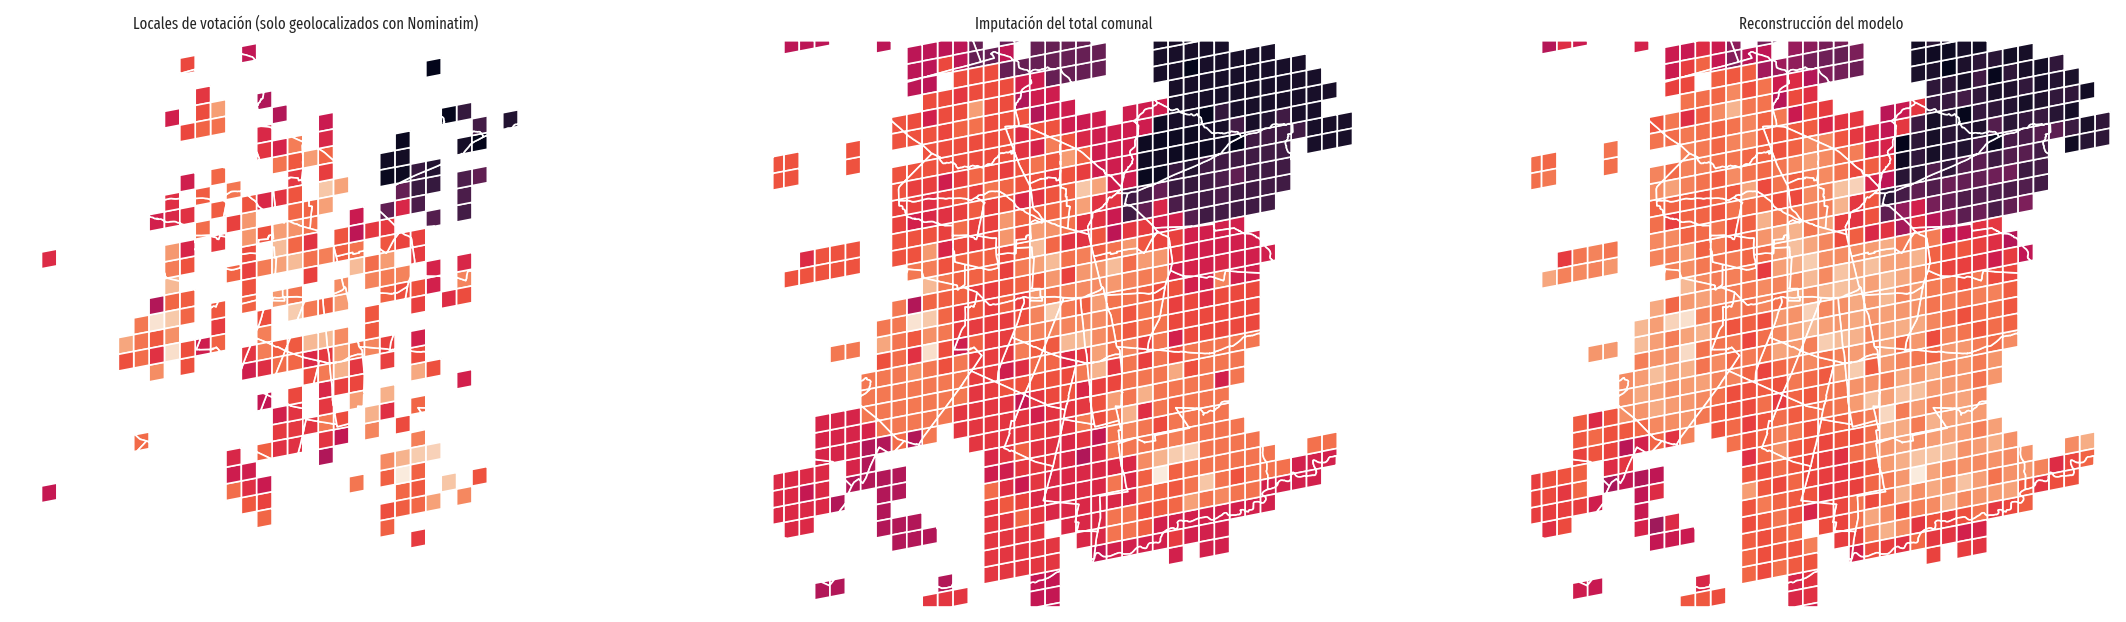

In [440]:
from aves.visualization.figures import small_multiples_from_geodataframe

fig, axes = small_multiples_from_geodataframe(grid, 3)

grid.join(turnout_geoloc["GABRIEL BORIC FONT"], on="s2_cellid", how="inner").plot(
    column="GABRIEL BORIC FONT", ax=axes[0]
)
axes[0].set_title("Locales de votación (solo geolocalizados con Nominatim)")

grid.join(all_cells_turnout["GABRIEL BORIC FONT"], on="s2_cellid", how="inner").plot(
    column="GABRIEL BORIC FONT", ax=axes[1]
)
axes[1].set_title("Con imputación del total comunal")

grid.join(
    model.reconstruct("grid", "candidatos")["GABRIEL BORIC FONT"],
    on="s2_cellid",
    how="inner",
).plot(column="GABRIEL BORIC FONT", ax=axes[2])
axes[2].set_title("Reconstrucción del modelo")


In [441]:
if False:
    from skfusion import fusion
    def model_new_relation(df, src_name, dst_name):
        return fusion.Relation(df.values, model.types[src_name], model.types[dst_name])

    new_relations = [
        (grid_x_comuna.T, "comunas", "grid"),
        (grid_x_age, "grid", "grupo_etareo"),
        (grid_x_income, "grid", "ingreso"),
        (turnout_geoloc.pipe(lambda x: ensure_index(x, grid_x_comuna)), "grid", "candidatos"),
    ]

    new_relations = map(lambda x: model_new_relation(*x), new_relations)

    print("reconstructing")
    new_graph = fusion.FusionGraph(list(new_relations))

    transformer = fusion.DfmfTransform()
    transformer.transform(model.types["grid"], new_graph, model.fuser)

    new_grid_profiles = model.relation_profiles(
        "grid",
        "candidatos",
        updated_factors={"grid": transformer.factor(model.types["grid"])},
        index=all_cells_turnout.index,
    )

In [442]:
from aves.features.utils import standardize_columns, standardize_rows


def prepare_matrix(x, std="col"):
    if std == "col":
        x = x.pipe(standardize_columns)
    elif std == "row":
        x = x.pipe(standardize_rows)

    return x / x.abs().max().max()


prediction_grid_x_abstencion = model.relation_profiles("grid", "abstencion")
# prediction_grid_x_abstencion = model.relation_profiles("grid", "abstencion", updated_factors={"grid": transformer.factor(model.types["grid"])},
#    index=all_cells_turnout.index)

prediction_grid_x_abstencion[0][1].T


<class 'skfusion.fusion.base.fusion_graph.ObjectType'> grid False (797, 128)
Relation(grid → candidatos)
Relation(candidatos → comunas)
Relation(comunas → abstencion)
<class 'skfusion.fusion.base.fusion_graph.ObjectType'> grid False (797, 128)
Relation(grid → candidatos)
Relation(candidatos → plebiscito)
Relation(plebiscito → comunas)
Relation(comunas → abstencion)


,10836387463459504128,10836387497819242496,10836387532178980864,10836426015085953024,10836426461762551808,10836426496122290176,10836426530482028544,10836426599201505280,10836426667920982016,10836426702280720384,...,10836481506063417344,10836482055819231232,10836482090178969600,10836482743013998592,10836482777373736960,10836548507553234944,10836548541912973312,10836548576272711680,10836548679351926784,10843879913648291840
Disminuye Votación\nRespecto a Plebiscito,0.423670,0.669473,0.587989,0.007994,0.022503,0.070063,0.170582,-0.055736,0.397504,0.395651,...,1.020903,0.996148,1.000927,1.074906,1.067779,0.574338,0.608543,0.626829,0.520735,-0.547490
Mantiene Votación\nRespecto a Plebiscito,-0.118919,-0.226187,-0.194381,0.076798,0.069536,0.051597,0.005917,0.101413,-0.095434,-0.102018,...,-0.382018,-0.372834,-0.373714,-0.412068,-0.403343,-0.176667,-0.193127,-0.196457,-0.150602,0.326149
Mayor Votación\nRespecto a Plebiscito,-0.113021,-0.237765,-0.197588,0.164224,0.165686,0.140153,0.079940,0.181507,-0.056899,-0.060332,...,-0.416889,-0.399996,-0.408356,-0.455381,-0.440634,-0.160729,-0.184306,-0.188405,-0.130361,0.495823


<AxesSubplot:>

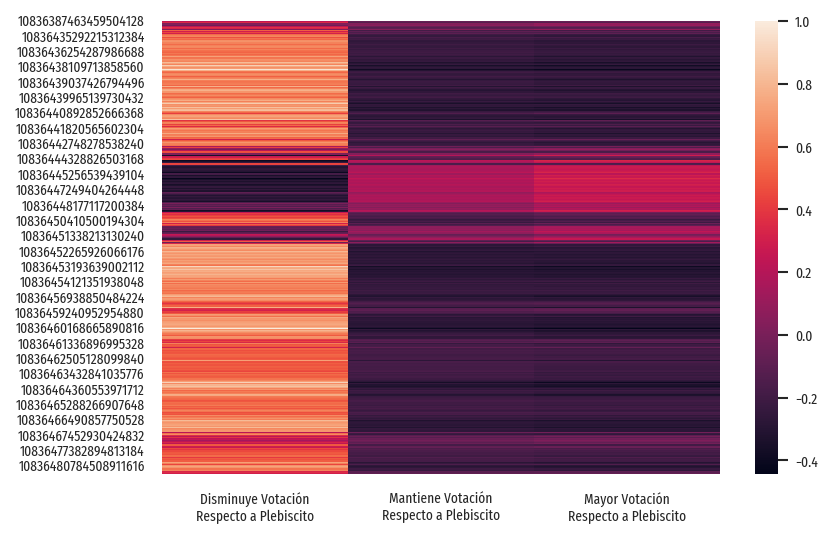

In [443]:
sns.heatmap(prediction_grid_x_abstencion[0][1].pipe(lambda x: prepare_matrix(x, std="none")))

In [455]:
import matplotlib.image as image
bird = image.imread('../data/external/bird_1f426.png')

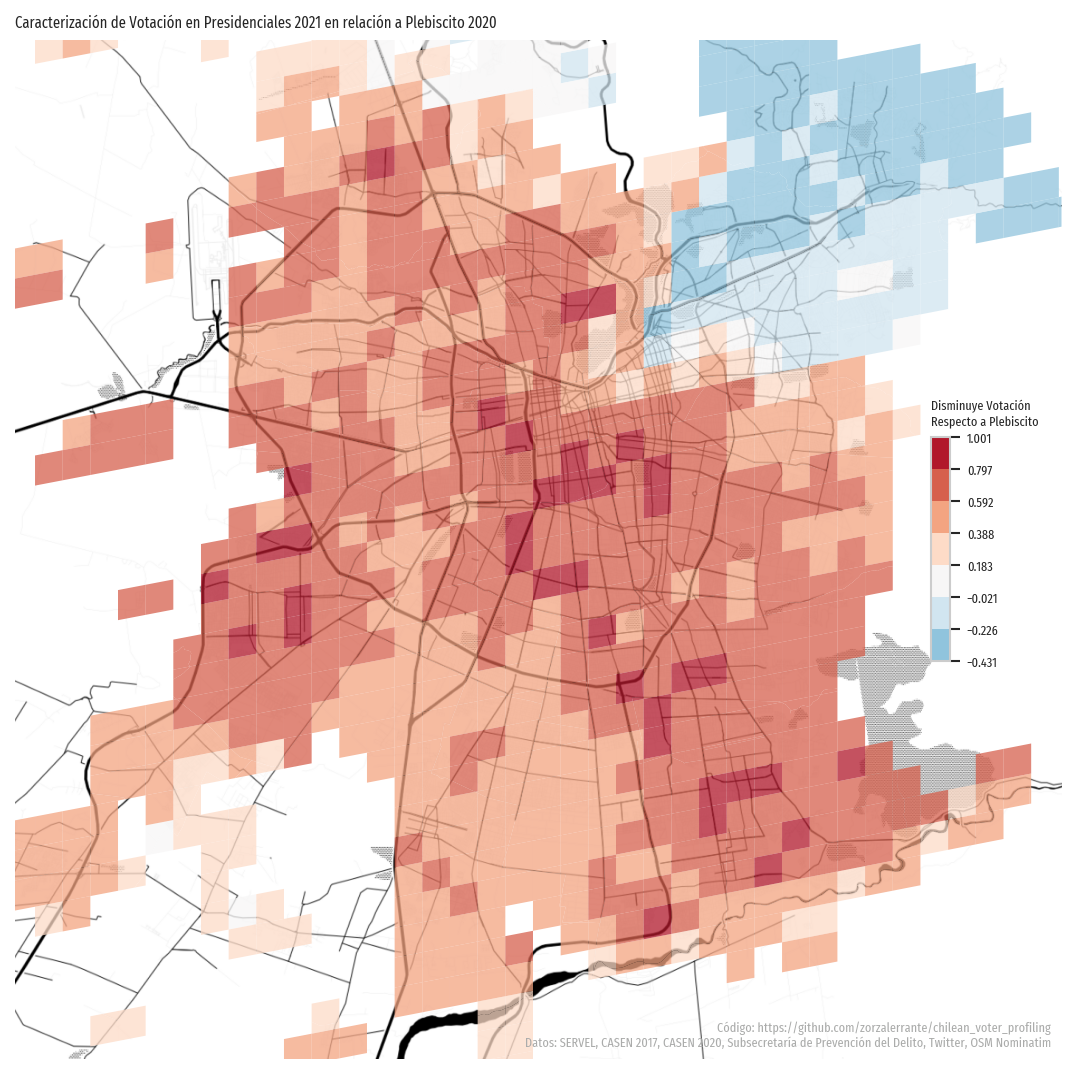

In [464]:
from aves.visualization.maps import choropleth_map
from aves.visualization.figures import GeoFacetGrid, figure_from_geodataframe

from aves.visualization.maps import choropleth_map

fig, ax = figure_from_geodataframe(grid, height=9, remove_axes=True, basemap='../data/external/scl_toner_12.tif')

ax, cax = choropleth_map(ax, grid.join(prediction_grid_x_abstencion[0][1].pipe(
            lambda x: prepare_matrix(x, std="none")
        ),
        on="s2_cellid",
        how="inner",
    ), "Disminuye Votación\nRespecto a Plebiscito", k=7, edgecolor='none', alpha=0.75, cbar_args=dict(
        label="Disminuye Votación\nRespecto a Plebiscito",
        height="22%",
        width="2%",
        orientation="vertical",
        location="center right",
        label_size="small",
        bbox_to_anchor=(0.0, 0.0, 0.9, 1.0),
    ))

ax.set_title('Caracterización de Votación en Presidenciales 2021 en relación a Plebiscito 2020', loc='left')

ax.annotate('Código: https://github.com/zorzalerrante/chilean_voter_profiling\nDatos: SERVEL, CASEN 2017, CASEN 2020, Subsecretaría de Prevención del Delito, Twitter, OSM Nominatim', xy=(0.99, 0.01), xycoords='axes fraction', ha='right', va='bottom', fontsize='small', color='#abacab')

fig.savefig('../reports/scl-geoloc-delta-abstencion.png', dpi=300, bbox_inches='tight')


In [465]:
grid.join(
    prediction_grid_x_abstencion[0][1].pipe(lambda x: prepare_matrix(x, std="none")),
    on="s2_cellid",
    how="inner",
)[
    ["s2_cellid", "geometry", "NOM_COMUNA"]
    + list(prediction_grid_x_abstencion[0][1].columns)
].to_file('../reports/scl-geoloc-delta-abstencion.geo.json', driver='GeoJSON')
